In [ ]:
import tensorflow as tf
import os
import random
import numpy as np

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

dataset = np.concatenate((x_train, x_test), axis=0)
dataset = np.expand_dims(dataset, axis=-1)
dataset = dataset.astype(np.float32) / 255.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


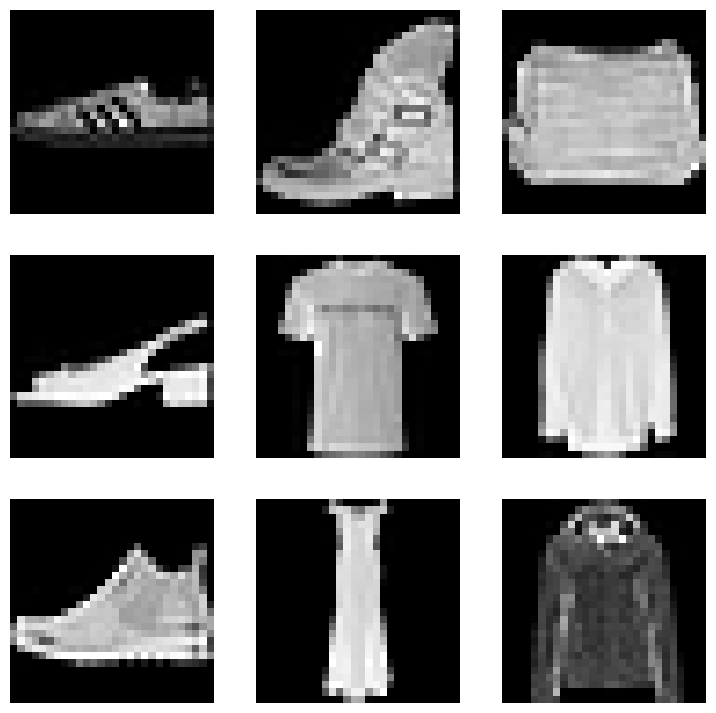

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(9,9))
rndsamples = np.random.randint(60000, size=9)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rndsamples[i]], cmap='gray')
    plt.axis('off')

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Reparameterization trick z = mu + sigma * epsilon
class SamplingLayer(layers.Layer):
    def call(self, inputs):
        zMean, zLogvar = inputs
        batch = tf.shape(zMean)[0]
        dim = tf.shape(zMean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return zMean + tf.exp(0.5 * zLogvar) * epsilon

In [ ]:
# Encoder network
def build_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    #layer to learn the mean
    zMean = layers.Dense(latent_dim, name='z_mean')(x)
    #layer to learn the variance
    zLogvar = layers.Dense(latent_dim, name='z_log_var')(x)
    #reparameterization to find z using mean and variance
    z = SamplingLayer()([zMean, zLogvar])

    return keras.Model(encoder_inputs, [zMean, zLogvar, z], name='encoder')
build_encoder(128).summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 128)    │          1,280 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 28, 28, 128)    │        147,584 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 100352)         │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │     25,690,368 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_layer            │ (None, 128)            │              0 │ z_mean[0][0],          │
│ (SamplingLayer)           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,905,024 (98.82 MB)

 Trainable params: 25,905,024 (98.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Decoder network
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7*7*216, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 216))(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    return keras.Model(latent_inputs, decoder_outputs, name='decoder')

build_decoder(128).summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10584)               │       1,365,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 216)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         248,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,688,665 (6.44 MB)

 Trainable params: 1,688,665 (6.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Loss functions
#the loss between the original image and the generated one
def reconstructionLoss(data ,reconstructed):
    return tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstructed), axis=(1,2)))

def kldivergenceLoss(zMean, zLogvar):
    return tf.reduce_mean(tf.reduce_sum(tf.exp(zLogvar) + zMean**2 - 1. - zLogvar, axis=1))

def totalLoss(data, reconstructed, zMean, zLogvar):
    loss1 = reconstructionLoss(data, reconstructed)
    loss2 = kldivergenceLoss(zMean, zLogvar)
    klweight = 3
    return loss1 , loss2, loss1 + klweight * loss2

In [ ]:
# Variational Autoencoder model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #register total loss as an observable metric in the model training history
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    #calculate the loss + calculate the gradient + update the weights
    def train_step(self, data):
        #tape is recording all the weights that needs to be updated
        with tf.GradientTape() as tape:
            #forward path
            zMean, zLogvar, z = self.encoder(data)
            reconstructed = self.decoder(z)
            reconstruction_loss, kl_loss, total_loss = totalLoss(data, reconstructed, zMean, zLogvar)
        #backward path
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        #keep track of the loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result()
        }

# Build and compile the VAE
latent_dim = 128
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Train the model
history = vae.fit(dataset, epochs=10, batch_size=128)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - kl_loss: 4.6146 - loss: 380.6084 - reconstruction_loss: 366.7645
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - kl_loss: 10.1338 - loss: 315.0312 - reconstruction_loss: 284.6297
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - kl_loss: 9.3272 - loss: 298.1191 - reconstruction_loss: 270.1376
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - kl_loss: 9.2178 - loss: 292.8088 - reconstruction_loss: 265.1553
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - kl_loss: 9.2119 - loss: 290.9226 - reconstruction_loss: 263.2868
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - kl_loss: 9.2855 - loss: 289.9158 - reconstruction_loss: 262.0593
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - kl_loss: 9.2945 - loss: 288.8333 - reconstruction_loss: 260.9499
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - kl_loss: 9.4498 - loss: 287.9505 - reconstruction_loss: 259.6011
Epoch 9/10
547/547 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


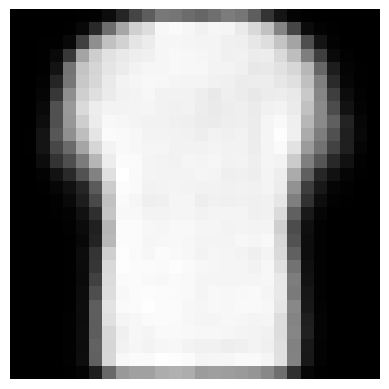

In [ ]:
# Assuming latent_dim is 128
latent_vector = np.random.randn(1, 128)  # Create a random latent vector with shape (1, 128)

synth = vae.decoder.predict(latent_vector)
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r")

RGB images

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset (which has RGB images)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the dataset to values between 0 and 1
dataset = np.concatenate((x_train, x_test), axis=0)
dataset = dataset.astype(np.float32) / 255.0

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Reparameterization trick z = mu + sigma * epsilon
class SamplingLayer(layers.Layer):
    def call(self, inputs):
        zMean, zLogvar = inputs
        batch = tf.shape(zMean)[0]
        dim = tf.shape(zMean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return zMean + tf.exp(0.5 * zLogvar) * epsilon

In [ ]:
# Encoder network
def build_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(32,32,3))  # RGB images
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    zMean = layers.Dense(latent_dim, name='z_mean')(x)
    zLogvar = layers.Dense(latent_dim, name='z_log_var')(x)
    z = SamplingLayer()([zMean, zLogvar])

    return keras.Model(encoder_inputs, [zMean, zLogvar, z], name='encoder')

In [ ]:
# Decoder network
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8*8*256, activation="relu")(latent_inputs)  # Adjust for CIFAR-10 size
    x = layers.Reshape((8, 8, 256))(x)  # Start with 8x8 size
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)  # Output 3 channels (RGB)

    return keras.Model(latent_inputs, decoder_outputs, name='decoder')

In [ ]:
# Loss functions
def reconstructionLoss(data ,reconstructed):
    return tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstructed), axis=(1,2)))

def kldivergenceLoss(zMean, zLogvar):
    return tf.reduce_mean(tf.reduce_sum(tf.exp(zLogvar) + zMean**2 - 1. - zLogvar, axis=1))

def totalLoss(data, reconstructed, zMean, zLogvar):
    loss1 = reconstructionLoss(data, reconstructed)
    loss2 = kldivergenceLoss(zMean, zLogvar)
    klweight = 3
    return loss1 , loss2, loss1 + klweight * loss2

In [ ]:
# Variational Autoencoder model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            zMean, zLogvar, z = self.encoder(data)
            reconstructed = self.decoder(z)
            reconstruction_loss, kl_loss, total_loss = totalLoss(data, reconstructed, zMean, zLogvar)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result()
        }

# Build and compile the VAE
latent_dim = 128
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Train the model
history = vae.fit(dataset, epochs=10, batch_size=128)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - kl_loss: 8.2113 - loss: 716.6474 - reconstruction_loss: 692.0133
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - kl_loss: 4.8466 - loss: 679.4887 - reconstruction_loss: 664.9493
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - kl_loss: 5.2357 - loss: 677.4239 - reconstruction_loss: 661.7168
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - kl_loss: 5.4336 - loss: 669.4819 - reconstruction_loss: 653.1812
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - kl_loss: 5.5092 - loss: 668.8395 - reconstruction_loss: 652.3118
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - kl_loss: 5.5776 - loss: 668.0842 - reconstruction_loss: 651.3514
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - kl_loss: 5.6334 - loss: 667.6392 - reconstruction_loss: 650.7391
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - kl_loss: 5.7191 - loss: 667.4419 - reconstru

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


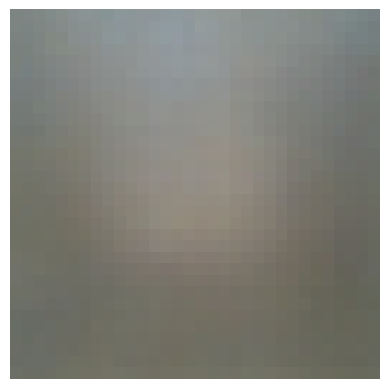

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming latent_dim is 128
latent_vector = np.random.randn(1, 128)  # Create a random latent vector with shape (1, 128)

# Generate a colored image from the latent vector
synth = vae.decoder.predict(latent_vector)

# Reshape the generated image to 32x32x3 (the correct output shape for CIFAR-10)
synth_reshaped = synth.reshape((32, 32, 3)) # Changed reshape dimensions to (32, 32, 3)

# Ensure the pixel values are in a valid range for display (0-1 or 0-255)
synth_reshaped = np.clip(synth_reshaped, 0, 1)

# Display the generated image
plt.axis('off')
plt.imshow(synth_reshaped)
plt.show()

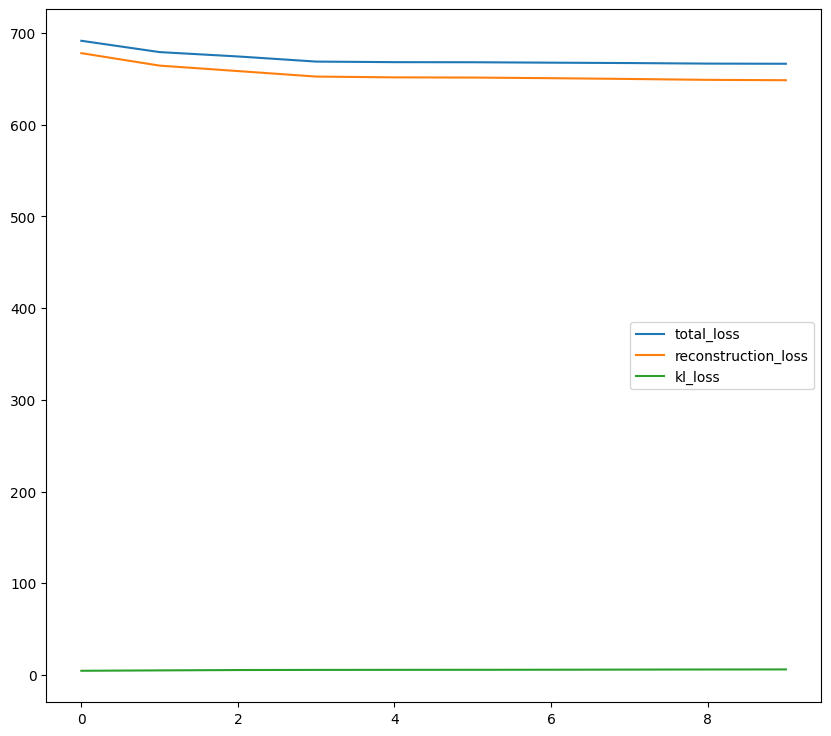

In [ ]:
plt.figure(figsize=(10,9))
plt.plot(history.history['loss'])
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['kl_loss'])
plt.legend(['total_loss', 'reconstruction_loss', 'kl_loss'])
plt.show()